In [1]:
import pandas as pd
from scipy.stats import beta, bernoulli, binom, bayes_mvs
from scipy.special import beta as beta_func
from scipy.special import gamma
from scipy.optimize import fmin
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
from matplotlib import gridspec

%matplotlib inline

plt.style.use('seaborn-white')
color = '#87ceeb'

In [2]:
def computeHDI(dist_rv, interval = .95):
    # Simple function based of off Kruschke's book.
    
    # Finds the low_tail_percentile which minimizes the width of
    # credible interval, while maintaining 95% of density.
    # Based off https://github.com/aloctavodia/Doing_bayesian_data_analysis/blob/master/HDIofICDF.py
    def interval_width(low_tail_percentile):
        return dist_rv.ppf(interval + low_tail_percentile) - dist_rv.ppf(low_tail_percentile)
    
    # Default the best guess to 1-interval.
    HDI_low_tail_percentile = fmin(interval_width, 1-interval, ftol=1e-8, disp=False)[0]
    return dist_rv.ppf([HDI_low_tail_percentile, interval + HDI_low_tail_percentile])

# Simple updating of prior (BetaPrior - BinomLikelihood)
We'll play around with simple analytical prior updating. Due to operating on Beta distribution family, we can use analytical methods for increased speed. Also might be useful in marketing purposes, where we operate mostly on binomial data (converters/non-converters).

In [3]:
# Prior
a = 50
b = 50
prior = beta(a, b)

# Likelihood
success = 20
trials = 100
p = success/trials
# Transformed the bernoulli into beta distribution, as their in the same family.
likelihood = beta(success+1, trials-success+1)

In [4]:
# Series of theta points for drawing out the posterior
bin_width = 0.0005
theta = np.arange(bin_width/2, 1-(bin_width/2)+bin_width, bin_width)
posterior_rv = beta(success+a, trials - success + b)
posterior = posterior_rv.pdf(theta)

# Simple credibility interval evaluation
# works best on unimodal distributions
lower, upper = computeHDI(posterior_rv)

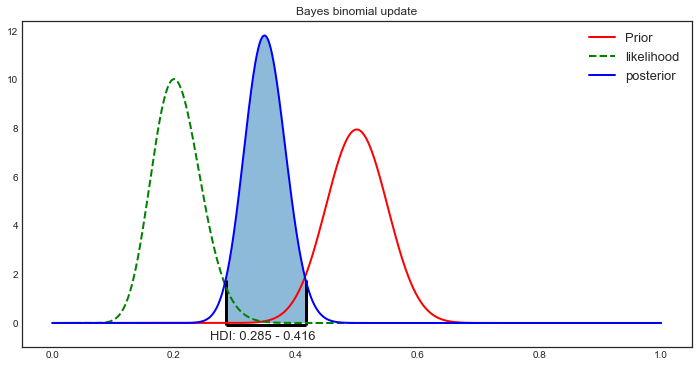

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

plt.ylim(-1, np.max(posterior)*1.05)
ax.plot(theta, prior.pdf(theta), 'r-', lw=2, label="Prior")
ax.plot(theta, likelihood.pdf(theta), 'g--', lw=2, label="likelihood")
ax.plot(theta, posterior, "b-", lw=2, label="posterior")
plt.fill_between(theta, 0, posterior, where=np.logical_and(theta>lower, theta<upper), alpha=0.5)
plt.hlines(y=-0.1, color="k", xmin=lower, xmax=upper, lw=3)
plt.vlines(x=lower, ymin=-0.1, ymax=posterior_rv.pdf(lower), color="k", lw=3)
plt.vlines(x=upper, ymin=-0.1, ymax=posterior_rv.pdf(upper), color="k", lw=3)
plt.text(x=((upper+lower)/2.7), y=-0.7, s=f"HDI: {lower:.3f} - {upper:.3f}", fontsize=13)
plt.title("Bayes binomial update")
ax.legend(fontsize=13)

# A/B Testing
Continuing with my mini-research for marketing, I'm going to do a test A/B test with fictional prior (which could be derived via an A/A test or account's performance).

In [6]:
# Global Prior
a = 50
b = 50
prior = beta(a, b)

# Likelihood for A
success_A = 20
trials_A = 100
p = success_A/trials_A
# Again likelihoods are given +1 to indicate transformation 
# from bernoulli dist to a beta one
likelihood_A = beta(success_A+1, trials_A-success_A+1)

# Likelihood for B
success_B = 3
trials_B = 100
p = success_B/trials_B
likelihood_B = beta(success_B+1, trials_B-success_B+1)

In [7]:
# Series of theta points for drawing out the posterior
bin_width = 0.0005
theta = np.arange(bin_width/2, 1-(bin_width/2)+bin_width, bin_width)

# Posterior for A
posterior_rv_A = beta(success_A+a, trials_A - success_A + b)
posterior_A = posterior_rv_A.pdf(theta)

# Posterior for B
posterior_rv_B = beta(success_B+a, trials_B - success_B + b)
posterior_B = posterior_rv_B.pdf(theta)

# Simple credibility interval evaluation
# works best on gaussian unimodal distributions
lower_A, upper_A = computeHDI(posterior_rv_A)
lower_B, upper_B = computeHDI(posterior_rv_B)

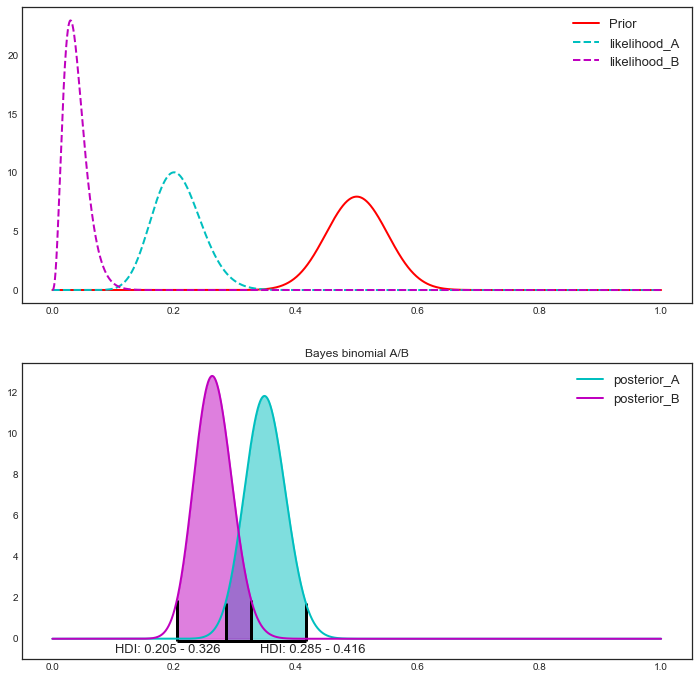

In [8]:
fig, ax = plt.subplots(2,1, figsize=(12,12))

plt.title("Bayes binomial A/B")
plt.ylim(-1, max(np.max(posterior_A), np.max(posterior_B))*1.05)
ax[0].plot(theta, prior.pdf(theta), 'r-', lw=2, label="Prior")

# A
ax[0].plot(theta, likelihood_A.pdf(theta), 'c--', lw=2, label="likelihood_A") 
ax[1].plot(theta, posterior_A, "c-", lw=2, label="posterior_A")
plt.fill_between(theta, 0, posterior_A, where=np.logical_and(theta>lower_A, theta<upper_A), alpha=0.5, color="c")
plt.hlines(y=-0.1, color="k", xmin=lower_A, xmax=upper_A, lw=3)
plt.vlines(x=lower_A, ymin=-0.1, ymax=posterior_rv_A.pdf(lower_A), color="k", lw=3)
plt.vlines(x=upper_A, ymin=-0.1, ymax=posterior_rv_A.pdf(upper_A), color="k", lw=3)
plt.text(x=lower_A*1.2, y=-0.7, s=f"HDI: {lower_A:.3f} - {upper_A:.3f}", fontsize=13)

# B
ax[0].plot(theta, likelihood_B.pdf(theta), 'm--', lw=2, label="likelihood_B") 
ax[1].plot(theta, posterior_B, "m-", lw=2, label="posterior_B")
plt.fill_between(theta, 0, posterior_B, where=np.logical_and(theta>lower_B, theta<upper_B), alpha=0.5, color="m")
plt.hlines(y=-0.1, color="k", xmin=lower_B, xmax=upper_B, lw=3)
plt.vlines(x=lower_B, ymin=-0.1, ymax=posterior_rv_B.pdf(lower_B), color="k", lw=3)
plt.vlines(x=upper_B, ymin=-0.1, ymax=posterior_rv_B.pdf(upper_B), color="k", lw=3)
plt.text(x=lower_B/2, y=-0.7, s=f"HDI: {lower_B:.3f} - {upper_B:.3f}", fontsize=13)

ax[0].legend(fontsize=13)
ax[1].legend(fontsize=13)

We can see that both of the posterior distributions overlap each other by a fair bit (within the 95% credible interval) meaning, that the results might not be statistically significant and *we need more data to make a proper decision*.

But let's see another way of measuring the difference. 
We can compare the lift's 95% credible region to the 1% ROPE to see if the results are meaningful there.

In [9]:
# Calculate the lift by bootstrapping the difference of both posteriors.
rvs = posterior_rv_A.rvs(size=1000000) - posterior_rv_B.rvs(size=1000000)
bins = np.linspace(np.min(rvs) - 0.2 * abs(np.min(rvs)), np.max(rvs) + 0.2 * abs(np.max(rvs)), 500)
# Using PyMC3's HDP calculation function for ease (it's actually Arviz from what I see).
# It also checks for the minimum valid width for the 95% interval and does so on unimodal distributions.
lower, upper = pm.stats.hpd(rvs)

lift = np.histogram(rvs, bins=bins, density=True)

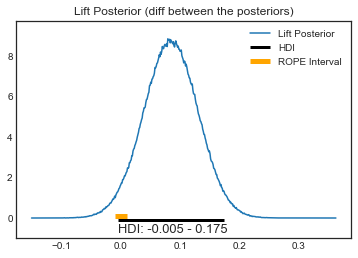

In [10]:
rope_interval = [-0.01, 0.01] # Set the Region of Practical Equivalence to 1%
plt.ylim(-1,np.max(lift[0])*1.1)
plt.plot(lift[1][:499], lift[0], label="Lift Posterior")
plt.title("Lift Posterior (diff between the posteriors)")
plt.hlines(y=-0.1, color="k", xmin=lower, xmax=upper, lw=3, label="HDI")
plt.hlines(y=0.1, color="orange", xmin=rope_interval[0], xmax=rope_interval[1], lw=5, label="ROPE Interval")
plt.text(x=lower, y=-0.7, s=f"HDI: {lower:.3f} - {upper:.3f}", fontsize=13)
plt.legend()
plt.show()

The Region of Practical Equivelence overlaps the HDI interval, meaning the results are inconclusive.

The HDI is also pretty wide, meaning more data is the way to go.

**TODO**: Function that calculates it all in one fell swoop. Although there's a great package that already does that, called [Abyes](https://github.com/cbellei/abyes) which was found via [this great blogpost](http://www.claudiobellei.com/2017/11/02/bayesian-AB-testing/)

And due to that great blog post, it might be a good idea to create a sub-section for exploring the `Expected Loss` as a decision rule.

**NOTE**: If you're working with priors that are not well modeled by the Beta distribution, we need to move into numerical methods.

# Probability of A beating B in the long run.
We can also try to estimate the probability of A beating B.    

## Numerical Estimation (slower)
We can estimate it by generating a ton of values for each posterior, and calculate how many values from posterior A are higher than from posterior B. Dividing it by the sample size, we'll get our percentage.

Inspired by:  
https://medium.com/hockey-stick/tl-dr-bayesian-a-b-testing-with-python-c495d375db4d

In [11]:
sample_size = 100000

A_samples = pd.Series([posterior_rv_A.rvs(1) for _ in range(sample_size)])
B_samples = pd.Series([posterior_rv_B.rvs(1) for _ in range(sample_size)])

prob_A_beats_B = sum(A_samples > B_samples)/sample_size
prob_A_beats_B

0.96735

## More analytical calculation (faster)
A binary based test to get the probability of B beating test A in the long run.  
Based of off [Evan Miller's blogpost](https://www.evanmiller.org/bayesian-ab-testing.html#binary_ab).

$Pr(p_B > p_A) = \displaystyle\sum_{i=0}^{\alpha_B-1} \frac{B(\alpha_B+i, \beta_B + \beta_A)}{(\beta_A+i)B(1+i, \beta_A)B(\alpha_B, \beta_B)}$

In [12]:
# Getting the values of posteriors
posterior_A_alpha = success_A + a 
posterior_A_beta = trials_A - success_A + b

posterior_B_alpha = success_B + a 
posterior_B_beta = trials_B - success_B + b

In [13]:
# If working without a prior and just having raw success/failures, 
# then it's important to add +1 to all of those, as this is how
# the Bernoulli > Beta parameter transformation works.
def probability_B_beats_A(alpha_A, beta_A, alpha_B, beta_B):
    total = 0.0
    for i in range(alpha_B): # Adds automatically -1
        total += beta_func(alpha_A+i, beta_B+beta_A) / ((beta_B+i) * beta_func(1+i, beta_B) * beta_func(alpha_A, beta_A))
        
    return total

# Swapping A with B because posterior A is somewhat better than posterior B.
prob = probability_B_beats_A(posterior_B_alpha, posterior_B_beta, posterior_A_alpha, posterior_A_beta)
print("The probability of A being better than B is:")
print(f"{prob*100:.2f}%")

The probability of A being better than B is:
96.78%


**Notes on long term probability**: Interesting to see that this method shows us that posterior A has 97% probability of beating posterior B **in the long run**. Which makes total sense, as if we tend to linearly increase both conversion (with their respective conversion rate) A will outdo B by a fair margin.

It's also important to note that this doesn't tell us by how much it'll increase our average - just that there's high probability of outperforming one another.
Combined with all this information, we can make some decisions. Personally, I wouldn't decide on any test yet, as they're both worse than the average (and previous tests signalled to us that we should hold off with the decision until more data is gathered).

## Simulation

In [14]:
# Generate random data for our posterior
alphas = np.ceil(np.random.uniform(50, 100, 100))
betas = np.ceil(np.random.uniform(50, 100, 100))
posteriors_alpha_beta_A = [(int(alpha), int(beta)) for alpha, beta in zip(alphas[:50], betas[:50])]
posteriors_alpha_beta_B = [(int(alpha), int(beta)) for alpha, beta in zip(alphas[50:], betas[50:])]


sample_size = 100000

similarity_agg = []
for posterior_A_params, posterior_B_params in zip(posteriors_alpha_beta_A, posteriors_alpha_beta_B):
    posterior_A_rv = beta(posterior_A_params[0], posterior_A_params[1])
    posterior_B_rv = beta(posterior_B_params[0], posterior_B_params[1])
    
    # Not the most efficient method, I agree.
    A_samples = pd.Series([posterior_A_rv.rvs(1) for _ in range(sample_size)])
    B_samples = pd.Series([posterior_B_rv.rvs(1) for _ in range(sample_size)])
    
    prob_A_beats_B_sim = sum(A_samples > B_samples)/sample_size
    
    # Again we check if posterior A beats B, so we swap.
    prob_A_beats_B_calc = probability_B_beats_A(posterior_B_params[0], posterior_B_params[1], posterior_A_params[0], posterior_A_params[1])
    
    similarity_pair = (prob_A_beats_B_sim, prob_A_beats_B_calc)
    
    similarity_agg.append(similarity_pair)

In [15]:
similarity_df = pd.DataFrame(similarity_agg)
similarity_df["close"] = np.isclose(similarity_df[0], similarity_df[1], rtol=0, atol=0.005)

In [16]:
similarity_df["close"].value_counts()

True    50
Name: close, dtype: int64

**Insights**: Both methods produce similar results (absolute difference of max 0.5%). But the numerical approach is much more processing heavy, thus, it's better to stick with Evan Miller's solution.

## More examples of calculating the probability of long run winner.
Still all the math was generated by [Evan's Miller blogpost](https://www.evanmiller.org/bayesian-ab-testing.html). Highly recommend it.

### A/B/C testing of binary outcomes. [[link](https://www.evanmiller.org/bayesian-ab-testing.html#binary_abc)]

$Pr(p_C > max\{p_A, p_B\}) = 1 - Pr(p_A > p_C) - Pr(p_B > p_C) + \displaystyle\sum_{i=0}^{\alpha_A-1} \sum_{j=0}^{\alpha_B-1} \frac{B(i+j+\alpha_C, \beta_A + \beta_B + \beta_C)}{(\beta_A+i)(\beta_B+j)B(1+i, \beta_A)B(1+j,\beta_B), B(\alpha_C, \beta_C)} $

In [17]:
# Getting the values of posteriors
posterior_A_alpha = success_A + a 
posterior_A_beta = trials_A - success_A + b

posterior_B_alpha = success_B + a 
posterior_B_beta = trials_B - success_B + b

# The C posterior will be our prior distribution.
posterior_C_alpha = a
posterior_C_beta = b

def probability_C_beats_A_and_B(alpha_A, beta_A, alpha_B, beta_B, alpha_C, beta_C):
    total = 0.0
    for i in range(alpha_A): # Range function adds automatically -1
        for j in range(alpha_B):
            total += beta_func(i+j+alpha_C, beta_A+beta_B+beta_C) / \
                     ((beta_A+i)*(beta_B+j) * beta_func(1+i, beta_A)*beta_func(1+j, beta_B) * beta_func(alpha_C, beta_C))
    
    prob = 1 - probability_B_beats_A(alpha_C, beta_C, alpha_A, beta_A) \
             - probability_B_beats_A(alpha_C, beta_C, alpha_B, beta_B) + total
    
    return prob

# We gonna measure if our prior will outperform our tests.
probability_C_beats_A_and_B(posterior_A_alpha, posterior_A_beta, posterior_B_alpha, posterior_B_beta, posterior_C_alpha, posterior_C_beta)

0.9936725880466837

**Insights:** Yep, it looks like both of our tests are performing much worse than our prior.

### A/B testing for count data [[link](https://www.evanmiller.org/bayesian-ab-testing.html#count_ab)]
$Pr(\lambda_1 > \lambda_2) = \displaystyle\sum_{k=0}^{\alpha_1-1} \frac{(\beta_1+\beta_2)^{(k+\alpha_2)}\beta_1^k\beta_2^{\alpha_2}}{(k+\alpha_2)B(k+1, \alpha_2)}$  
> $\beta$ values represent exposure, that is the relative opportunity for events to occur.   
> $\lambda$ are the Poisson parameters for each group, with gamma-distributed prior belief.

In [18]:
prob_1_alpha = 30
prob_1_beta = 1

prob_2_alpha = 50
prob_2_beta = 2

def probability_1_beats_2(alpha_1, beta_1, alpha_2, beta_2):
    total = 0.0
    for k in range(alpha_1): # Adds automatically -1
        total += (beta_1+beta_2)**(-(k+alpha_2)) * beta_1**k * beta_2**alpha_2 / \
                 ((k+alpha_2) * beta_func(k+1, alpha_2))
        
    return total

probability_1_beats_2(prob_1_alpha, prob_1_beta, prob_2_alpha, prob_2_beta)

0.7767427780272981

### A/B/C testing for count data [[link](https://www.evanmiller.org/bayesian-ab-testing.html#count_abc)]
$Pr(\lambda_1 > max\{\lambda_2, \lambda_3\}) = 1 - Pr(\lambda_2 > \lambda_1) - Pr(\lambda_3 > \lambda_1) + \displaystyle\sum_{k=0}^{\alpha_2-1} \sum_{l=0}^{\alpha_3-1} \frac{\beta_1^{\alpha_1}\beta_2^{k}\beta_3^l}{(\beta_1 + \beta_2 + \beta_3)^{(k+l+\alpha_1)}} \frac{\Gamma(k+l+\alpha_1)}{\Gamma(k+1)\Gamma(l+1)\Gamma(\alpha_1)} $

> $\beta$ is the exposure rate of group.  
> $\lambda$ is the arrival rate for group.

In [19]:
prob_1_alpha = 30
prob_1_beta = 1

prob_2_alpha = 50
prob_2_beta = 2

prob_3_alpha = 90
prob_3_beta = 3

def probability_1_beats_2_and_3(alpha_1, beta_1, alpha_2, beta_2, alpha_3, beta_3):
    total = 0.0
    for k in range(alpha_2): # Adds automatically -1
        for l in range(alpha_3):
            total += ( (beta_1**alpha_1 * beta_2**k * beta_3**l)/((beta_1+beta_2+beta_3)**(k+l+alpha_1)) ) \
                     * ( (gamma(k+l+alpha_1))/(gamma(k+1) * gamma(l+1) * gamma(alpha_1)) )
    prob = 1 - probability_1_beats_2(prob_2_alpha, prob_2_beta, prob_1_alpha, prob_1_beta) \
             - probability_1_beats_2(prob_3_alpha, prob_3_beta, prob_1_alpha, prob_1_beta) + total
        
    return prob

probability_1_beats_2_and_3(prob_1_alpha, prob_1_beta, prob_2_alpha, prob_2_beta, prob_3_alpha, prob_3_beta)

0.4621042000233466

**Note**: As you can see this is merely a re-writing of Evan's Miller formular in Python. He mentioned that beta values might be really high, thus sometimes producing NaN's as output. To prevent this, one should work with logarithms and log-beta functions. I'm skipping this for now as this doesn't seem crucial for the analysis I was doing while exploring.

# Bayes factor
> The bayes factor is a likelihood ratio of the marginal likelihood of two competing hypotheses usually a null and an alternative. [1]

1: [Wikipedia article on Bayes Factor](https://en.wikipedia.org/wiki/Bayes_factor)

## Simple BF calculations using Beta distributions.
If our main objective is a comparison of two models, we can just:

$\displaystyle BF = \frac{p(y|M_0)}{p(y|M_1)}$

Which basically compares the probability of the data value encountered under two competing hypothesis (in this case, $M_0$ and $M_1$)

Let's say we have two competing hypothesis, both which try to explain the more probable scenario of observed conversion rate.  
One of the models assumes a 50% conversion rate, while the second one, 65%. Both our models will be using beta as it's distribution of choice. Please note that if we'd use a discrete distribution, like a binomial one, the BF would be different, especially if we try to model our distribution further from the probability of 0.5. This is caused by the fact that beta distributions are slightly skewed when approaching 0 or 1 when the mean of probability is 1. This depends on the sample size (N) of course, as higher numbers will make the distribution much more compact and less skewed in the process. If it's approaching infinity, it will be more and more equal.
Observed data is that 68 conversions happened in 120 trials.

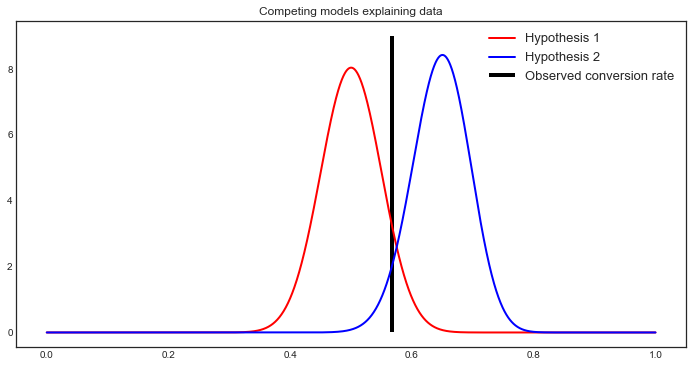

In [20]:
# Observed data.
conversions = 68
trials = 120
conversion_rate = conversions/trials
# Hypothesis
hypothesis_1 = beta(51, 51) # Adding one to convert from binom to beta
hypothesis_2 = beta(66, 36) #

# Show the hypothesis
bin_width = 0.0005
theta = np.arange(bin_width/2, 1-(bin_width/2)+bin_width, bin_width)
fig, ax = plt.subplots(1,1, figsize=(12,6))
plt.vlines(x=conversion_rate, ymin=0, ymax=9, color="k", lw=4, label="Observed conversion rate")
ax.plot(theta, hypothesis_1.pdf(theta), 'r-', lw=2, label="Hypothesis 1")
ax.plot(theta, hypothesis_2.pdf(theta), "b-", lw=2, label="Hypothesis 2")
plt.title("Competing models explaining data")
ax.legend(fontsize=13)
plt.show()

We can already clearly see, that Hypothesis 1 has a slight edge in explaining the observed conversion rate. This is further confirmed by the Bayesian factor.

In [21]:
hypothesis_1.pdf(conversion_rate)/hypothesis_2.pdf(conversion_rate)

1.6475159254102938

For easier interpretation for the strength of the model, here's a table:
> 1-3: Slight  
> 3-10: Substantial  
> 10-30: Strong  
> 30-100: Very Strong  

If the numbers are below 1, it means that the support shifted to the second hypothesis.

### Modify the prior distributions
To influence the degree of sureness, we're gonna tinker with the beta distribution to reflect some changes in how sure we are about the model being correct.  
This will influence the BF, which is helpful as this means that BF takes certainty into account when choosing an appropriate model.

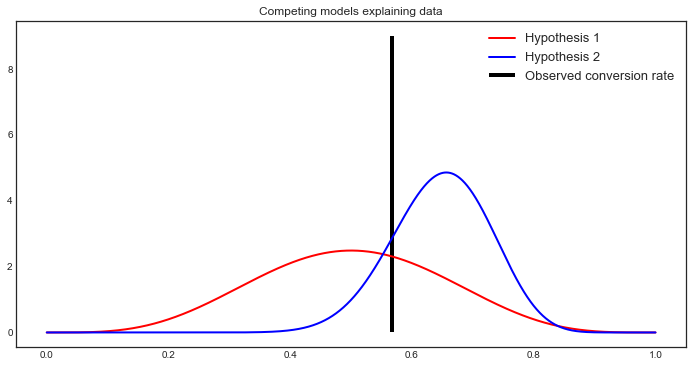

In [22]:
# Observed data.
conversions = 68
trials = 120
conversion_rate = conversions/trials
# Hypothesis
hypothesis_1 = beta(51/10, 51/10) # Adding one to convert from binom to beta
hypothesis_2 = beta(66/3, 36/3)

# Show the hypothesis
bin_width = 0.0005
theta = np.arange(bin_width/2, 1-(bin_width/2)+bin_width, bin_width)
fig, ax = plt.subplots(1,1, figsize=(12,6))
plt.vlines(x=conversion_rate, ymin=0, ymax=9, color="k", lw=4, label="Observed conversion rate")
ax.plot(theta, hypothesis_1.pdf(theta), 'r-', lw=2, label="Hypothesis 1")
ax.plot(theta, hypothesis_2.pdf(theta), "b-", lw=2, label="Hypothesis 2")
plt.title("Competing models explaining data")
ax.legend(fontsize=13)
plt.show()

In [23]:
hypothesis_1.pdf(conversion_rate)/hypothesis_2.pdf(conversion_rate)

0.8120119165118151

We can see that after we decrease the degree of certainty for our models, leaving the second hypothesis a bit more sure of itself, the tides have changed, although still very slightly. This means that there is no conclusive model.